In [ ]:
# Selecting v1.15 of tf
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
# Checking that I use the correct version
print(tensorflow.__version__)

1.15.2


In [ ]:
# Connect to gdrive to read csv file
from google.colab import drive
# Set force_remount=True to ensure any changed file is mounted
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Import libraries and useful functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed, Bidirectional, LeakyReLU
from keras.optimizers import Adam
import sys
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import mean_squared_error

from matplotlib.colors import ListedColormap
%matplotlib inline
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

#To display all columns/rows in the dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data

df=pd.read_csv('/content/gdrive/My Drive/stock_pred/final_dataset.csv',
               sep = ';',
               index_col='Date')

df.index=pd.to_datetime(df.index)

In [ ]:
# Some pre-processing
df = df.fillna(method='bfill')

In [ ]:
# Train-Val-Test Split

series=df

train_start = dt.date(2008,8,8)
train_end = dt.date(2013,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2014,1,1)
val_end = dt.date(2015,3,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2015,4,1)
test_end = dt.date(2016,6,30)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(1359, 22) (313, 22) (315, 22)


In [ ]:
# Normalisation

scaler = MinMaxScaler()
train = scaler.fit_transform(train_data)
val = scaler.transform(val_data)
test = scaler.transform(test_data)
print(train.shape,val.shape,test.shape)

(1359, 22) (313, 22) (315, 22)


In [ ]:
X_train = []
Y_train = []

X_val = []
Y_val = []

X_test = []
Y_test = []

# Look at last 21 days, predict the 22nd
seq_length = 21

# Loop for training data
for i in range(seq_length,train.shape[0]):
    X_train.append(train[i-seq_length:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for validation data
for i in range(seq_length,val.shape[0]):
    X_val.append(val[i-seq_length:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

# Loop for testing data
for i in range(seq_length,test.shape[0]):
    X_test.append(test[i-seq_length:i])
    Y_test.append(test[i][0])
X_test,Y_test = np.array(X_test),np.array(Y_test)

In [ ]:
# Hyperparameters
lr=0.01
epochs=100
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

# Define model
model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LeakyReLU(0.1))

model.add(LSTM(64))
model.add(LeakyReLU(0.1))

model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

[INFO] training model...

Train on 1338 samples, validate on 292 samples
Epoch 1/100
1338/1338 [==============================] - 4s 3ms/step - loss: 0.0525 - val_loss: 0.4581
Epoch 2/100
1338/1338 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0253
Epoch 3/100
1338/1338 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 0.0364
Epoch 4/100
1338/1338 [==============================] - 3s 2ms/step - loss: 5.4787e-04 - val_loss: 0.0295
Epoch 5/100
1338/1338 [==============================] - 3s 2ms/step - loss: 6.6503e-04 - val_loss: 0.0336
Epoch 6/100
1338/1338 [==============================] - 3s 2ms/step - loss: 6.8868e-04 - val_loss: 0.0294
Epoch 7/100
1338/1338 [==============================] - 3s 2ms/step - loss: 7.3639e-04 - val_loss: 0.0347
Epoch 8/100
1338/1338 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 0.0374
Epoch 9/100
1338/1338 [==============================] - 3s 2ms/step - loss: 5.0489e-04

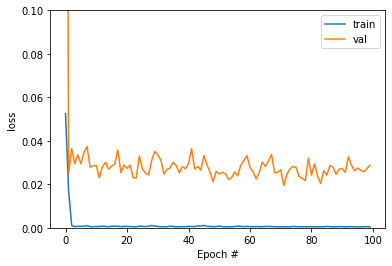

In [ ]:
# Plot the losses during the training

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='val')
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend()
plt.ylim(top=0.1, bottom=0)
plt.show()

In [ ]:
# Need to denormalize the target variable in all the sets

## Train
y_train_min = train_data.min()[0]
y_train_max = train_data.max()[0]
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()[0]
y_val_max = val_data.max()[0]
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()[0]
y_test_max = test_data.max()[0] 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [ ]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.22480723104806738
MSE (validation): 6.156359803652301
MSE (test): 35.57483027774671


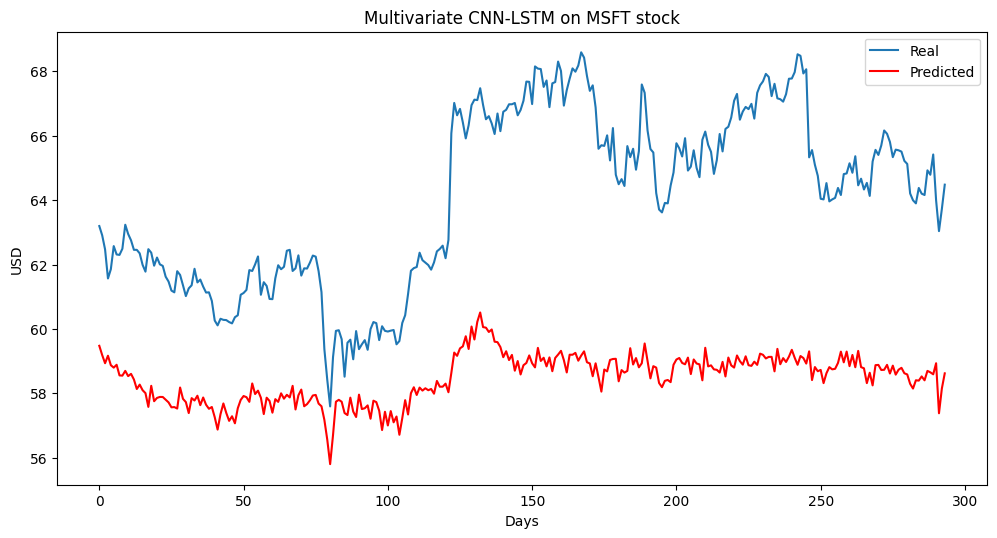

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Multivariate Bi-LSTM on MSFT stock')
plt.legend()
plt.show()

In [ ]:
import sys
import time

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from keras.callbacks import EarlyStopping


# Will use Hyper-Opt to find the optimum parameters for the regressor

#Will set an EarlyStopping callback:
# - [monitor]: look at validation loss
# - [min_delta]: quantify the loss amount
# - [patience]: nr of epochs before stopping
# - [verbose]: what to print
# - [mode]: the direction we want to track (e.g. min, max)

def get_callbacks(pars):
  callbacks = [EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0.001, 
                             patience = 2, 
                             verbose= 0, 
                             mode = 'auto')]
  return callbacks

# Defining the space in which fmin() will iterate:

space = {'neurons1': hp.choice('neurons1', [64, 128, 256]),
         'neurons2': hp.choice('neurons2', [64, 128, 256]),
         'lr': hp.choice('lr',[0.01, 0.001]),
         'activation_fn1': hp.choice('activation_fn1',['sigmoid','tanh','relu'])
        }

def bi_LSTM(pars):
  print('Parameters: ', pars)

  # Define the 2 neuron layers
  model = Sequential()
  model.add(Bidirectional(LSTM(pars['neurons1'],
                          return_sequences=True),
                          input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(pars['neurons2'], activation = pars['activation_fn1']))

  # Last unique linear activation for regression
  model.add(Dense(1, activation = 'linear'))

  # Define optimizer with learning rate as optimizable parameter 
  opt = Adam(lr = pars['lr'], decay = pars['lr'])
  
  # Compile the model
  model.compile(optimizer = opt, loss = 'mean_squared_error')

  # We now train the model
  history = model.fit(x=X_train, 
                      y=Y_train, 
					            validation_data=(X_val, Y_val),
	                    epochs = 10, 
                      batch_size = 32,
                      callbacks = get_callbacks(pars))
  
  # Save the losses and print them
  best_epoch_loss = np.argmin(history.history['val_loss'])
  best_val_loss = np.min(history.history['val_loss'])
  print('Epoch {} -  val loss: {}'.format(best_epoch_loss, best_val_loss))
  
  #This will let us see the progress while the script is running
  sys.stdout.flush()

  return {'loss': best_val_loss, 'best_epoch': best_epoch_loss, 
          'eval_time': time.time(), 'status': STATUS_OK, 'model': model, 
          'history': history}

trials = Trials()
# Use of fmin(), in which we put: 
#   - the defined function to minimize, 
#   - our space to iterate
#   - algorithm used: Tree of Parsen Estimators (TPE)
#   - maximum nr of evaluations 
#   - trials are used to see the results of each evaluation
best = fmin(bi_LSTM, space, algo = tpe.suggest, max_evals = 10, trials = trials)
print(best)

Se han truncado las últimas 5000 líneas del flujo de salida.

1120/1338 [========================>.....]
 - ETA: 0s - loss: 0.0125

1152/1338 [========================>.....]
 - ETA: 0s - loss: 0.0124

1184/1338 [=========================>....]
 - ETA: 0s - loss: 0.0124

1216/1338 [==========================>...]
 - ETA: 0s - loss: 0.0124

1248/1338 [==========================>...]
 - ETA: 0s - loss: 0.0125

1280/1338 [===========================>..]
 - ETA: 0s - loss: 0.0123

1312/1338 [============================>.]
 - ETA

In [ ]:
trials.losses()

[0.0065838714602263005,
 0.007552651985275737,
 0.001481894703505382,
 0.09427867901243575,
 0.0043835215803159225,
 0.0017057512472192311,
 0.031731166736516235,
 0.0014754035992528734,
 0.002811244746338423,
 0.06499000381014935]

In [ ]:
trials.trials[7]

{'book_time': datetime.datetime(2020, 8, 9, 13, 17, 48, 167000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'activation_fn1': [7], 'lr': [7], 'neurons1': [7], 'neurons2': [7]},
  'tid': 7,
  'vals': {'activation_fn1': [2], 'lr': [1], 'neurons1': [2], 'neurons2': [2]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 8, 9, 13, 19, 6, 197000),
 'result': {'best_epoch': 3,
  'eval_time': 1596979146.197616,
  'history': <keras.callbacks.callbacks.History at 0x7f8e01a3dc88>,
  'loss': 0.0014754035992528734,
  'model': <keras.engine.sequential.Sequential at 0x7f8e0201ec50>,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 7,
 'version': 0}

In [ ]:
# Hyperparameters
lr=0.001
epochs=50
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

# Define model
model = Sequential()

model.add(Bidirectional(LSTM(256, return_sequences=True),
                        input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(256, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

[INFO] training model...
Train on 1338 samples, validate on 292 samples
Epoch 1/50
1338/1338 [==============================] - 16s 12ms/step - loss: 0.0342 - val_loss: 0.0094
Epoch 2/50
1338/1338 [==============================] - 13s 10ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 3/50
1338/1338 [==============================] - 13s 10ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 4/50
1338/1338 [==============================] - 13s 10ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 5/50
1338/1338 [==============================] - 14s 10ms/step - loss: 9.6835e-04 - val_loss: 0.0069
Epoch 6/50
1338/1338 [==============================] - 13s 10ms/step - loss: 9.1577e-04 - val_loss: 0.0014
Epoch 7/50
1338/1338 [==============================] - 13s 10ms/step - loss: 8.1793e-04 - val_loss: 0.0023
Epoch 8/50
1338/1338 [==============================] - 13s 10ms/step - loss: 7.5541e-04 - val_loss: 0.0011
Epoch 9/50
1338/1338 [==============================] - 13s 10ms/step - loss: 7.

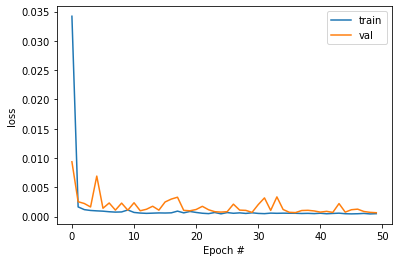

In [ ]:
# Plot the losses during the training

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='val')
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend()
#plt.ylim(top=1)
plt.show()

In [ ]:
# Need to denormalize the target variable in all the sets

## Train
y_train_min = train_data.min()[0]
y_train_max = train_data.max()[0]
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()[0]
y_val_max = val_data.max()[0]
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()[0]
y_test_max = test_data.max()[0] 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [ ]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.27261557395869346
MSE (validation): 0.13993691074887554
MSE (test): 0.39859861882129477


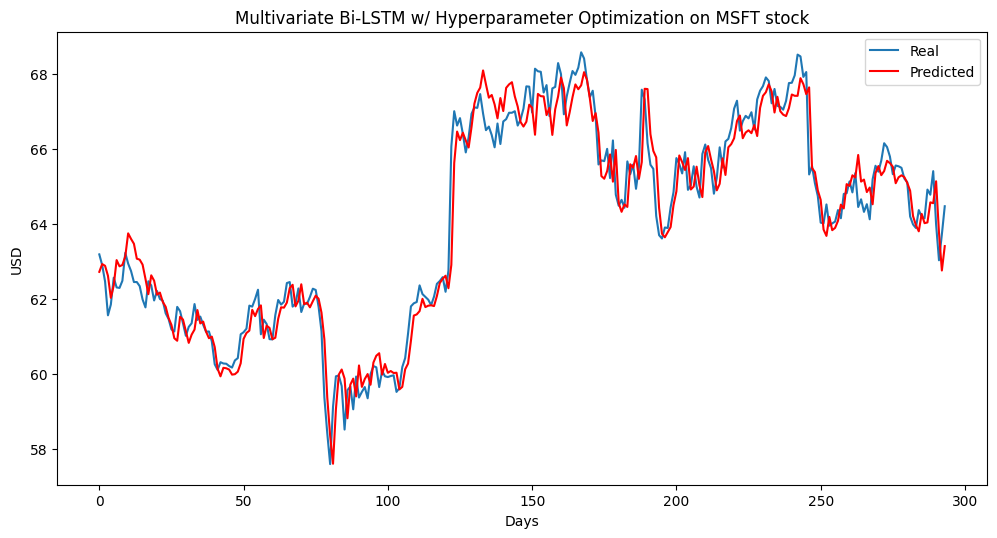

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Multivariate Bi-LSTM w/ Hyperparameter Optimization on MSFT stock')
plt.legend()
plt.show()